# Capstone Project: Classifying clinically actionable genetic mutations

***

## Notebook 2: Pre-processing and EDA

This notebook contains code for pre-processing and additional EDA of the datasets.

### Contents

- [Importing of Libraries](#Importing-of-Libraries)
- [Data Import](#Data-Import)

## Importing of Libraries

In [72]:
# pip install imblearn

In [5]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.utils import resample

from imblearn.over_sampling import SMOTE

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet

from collections import Counter
from wordcloud import WordCloud

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


## Data Import

In [6]:
# Import the datasets
train = pd.read_csv("../assets/train_clean.csv", keep_default_na=False)
test = pd.read_csv("../assets/test_clean.csv", keep_default_na=False)

In [7]:
train.shape, test.shape

((3321, 5), (986, 4))

In [8]:
train.head()

,id,text,gene,variation,class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


In [9]:
test.head()

,id,text,gene,variation
0,1,The incidence of breast cancer is increasing i...,CHEK2,H371Y
1,2,An unselected series of 310 colorectal carcino...,AXIN2,Truncating Mutations
2,3,Mycosis fungoides and SÃ©zary syndrome are pri...,WNT4,E216G
3,4,Regulated progression through the cell cycle ...,SUCLA2,G118R
4,5,Pilocytic astrocytoma (PA) is emerging as a tu...,BRAF,T599insTT


## Pre-processing

### Text Lemmatisation

In [10]:
# We define a function to preprocess the text
def preprocess(input_string):
    text_lower = BeautifulSoup(input_string).get_text().lower()
    return re.sub("[^a-zA-Z]", " ", text_lower) # we lower the case, and remove punctuation

In [11]:
# We define a function to perform POS (Parts-of-Speech) tagging which should improve the lemmatisation output
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) # Return wordnet.NOUN if the 'tag' key is not found

In [12]:
def lemmatize(input_string):
    
    # Lemmatise each word of text
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(input_string)
    lemmatizer = WordNetLemmatizer()
    # tokens_lem = [lemmatizer.lemmatize(i) for i in tokens]
    tokens_lem = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]

    # Remove stopwords
    
    stopwords = nltk.corpus.stopwords.words('english')
    new_stop_words = ['mutation', 'figure', 'fig', 'tumor', 'cell', 'patient', \
                     'use', 'et', 'al', 'also', 'cancer', 'show']
    stopwords.extend(new_stop_words)
    
    stops = set(stopwords)
    
    meaningful_words = [w for w in tokens_lem if not w in stops]
    
    # Join the words back into one string separated by space, and return the result
    return(" ".join(meaningful_words))

In [13]:
%%time
train['text_preproc'] = [preprocess(i) for i in list(train['text'])]
test['text_preproc'] = [preprocess(i) for i in list(test['text'])]

Wall time: 54 s


In [14]:
%%time
# Add new columns to hold lemmatised text
train['lemm_text'] = [lemmatize(i) for i in list(train['text_preproc'])]
test['lemm_text'] = [lemmatize(i) for i in list(test['text_preproc'])]

Wall time: 5h 39min 11s


In [15]:
train.head()

,id,text,gene,variation,class,text_preproc,lemm_text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate a var...,cyclin dependent kinase cdks regulate variety ...
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2,abstract background non small cell lung cance...,abstract background non small lung nsclc heter...
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2,abstract background non small cell lung cance...,abstract background non small lung nsclc heter...
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3,recent evidence has demonstrated that acquired...,recent evidence demonstrate acquire uniparenta...
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4,oncogenic mutations in the monomeric casitas b...,oncogenic monomeric casitas b lineage lymphoma...


In [16]:
test.head()

,id,text,gene,variation,text_preproc,lemm_text
0,1,The incidence of breast cancer is increasing i...,CHEK2,H371Y,the incidence of breast cancer is increasing i...,incidence breast increase china recent decade ...
1,2,An unselected series of 310 colorectal carcino...,AXIN2,Truncating Mutations,an unselected series of colorectal carcino...,unselected series colorectal carcinoma stratif...
2,3,Mycosis fungoides and SÃ©zary syndrome are pri...,WNT4,E216G,mycosis fungoides and s zary syndrome are pri...,mycosis fungoides zary syndrome primary cutane...
3,4,Regulated progression through the cell cycle ...,SUCLA2,G118R,regulated progression through the cell cycle r...,regulate progression cycle require sequential ...
4,5,Pilocytic astrocytoma (PA) is emerging as a tu...,BRAF,T599insTT,pilocytic astrocytoma pa is emerging as a tu...,pilocytic astrocytoma pa emerge entity dysregu...


In [17]:
# Remove the redundant 'text'-related columns
train.drop(columns=['text', 'text_preproc'], inplace=True)
test.drop(columns=['text', 'text_preproc'], inplace=True)

In [18]:
# Rename the lemm_text columns
train.rename(columns={'lemm_text':'text'}, inplace=True)
test.rename(columns={'lemm_text':'text'}, inplace=True)

## EDA on lemmatised text

### Word Cloud for descriptive text

In [19]:
train.head()

,id,gene,variation,class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small lung nsclc heter...
2,2,CBL,Q249E,2,abstract background non small lung nsclc heter...
3,3,CBL,N454D,3,recent evidence demonstrate acquire uniparenta...
4,4,CBL,L399V,4,oncogenic monomeric casitas b lineage lymphoma...


In [20]:
def word_count(input_string):
    tokenizer = RegexpTokenizer(r'[A-Za-z0-9]{2,}')
    words = tokenizer.tokenize(input_string)
    counter.update(words)

In [21]:
# Create a word frequency dictionary for class 7 variations
counter = Counter()
for input_string in train['text']:
    word_count(input_string)
train_word_freq = dict(counter.most_common())

In [22]:
# Determine size of word frequency dictionary
len(counter)

81294

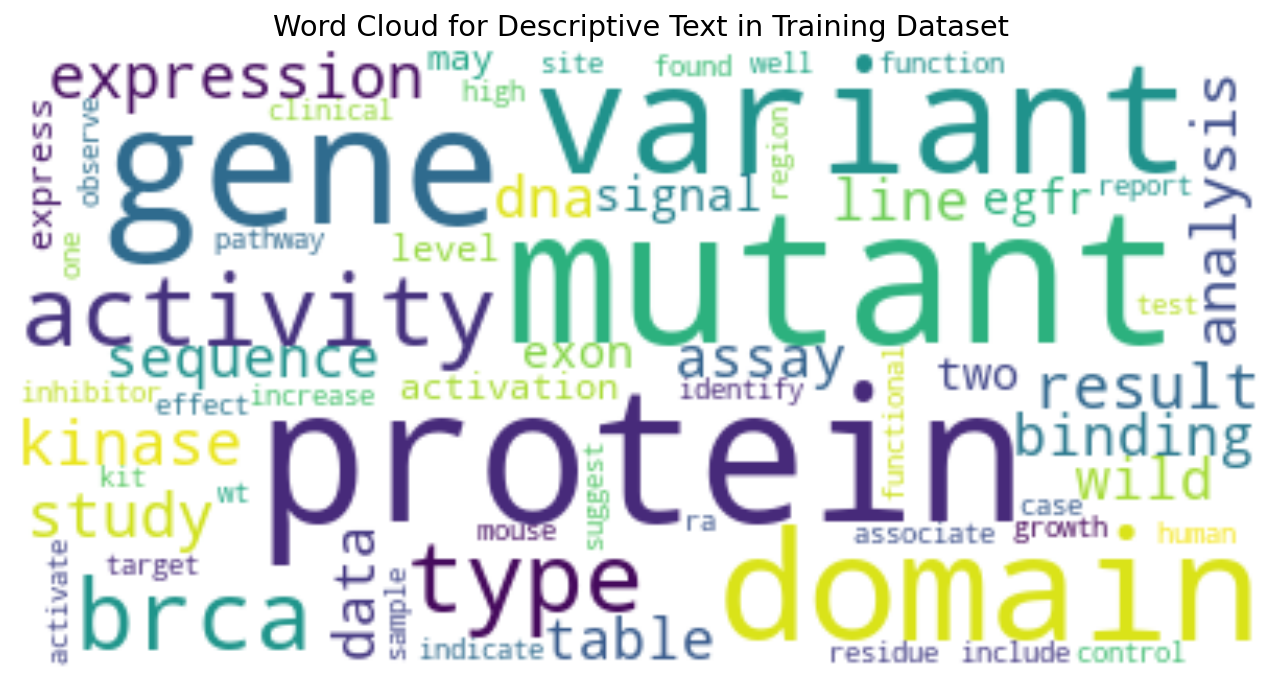

In [23]:
# Generate a word cloud image
wordcloud = WordCloud(max_font_size=60, background_color ='white', min_font_size = 8).generate_from_frequencies(train_word_freq)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Descriptive Text in Training Dataset")
plt.show()

### Histogram of 20 most frequent words in Training Dataset

In [24]:
labels, values = zip(*train_word_freq.items())
# sort your values in descending order
indSort = np.argsort(values)[::-1]
# rearrange your data
labels = np.array(labels)[indSort][:20]
values = np.array(values)[indSort][:20]
indexes = np.arange(len(labels))

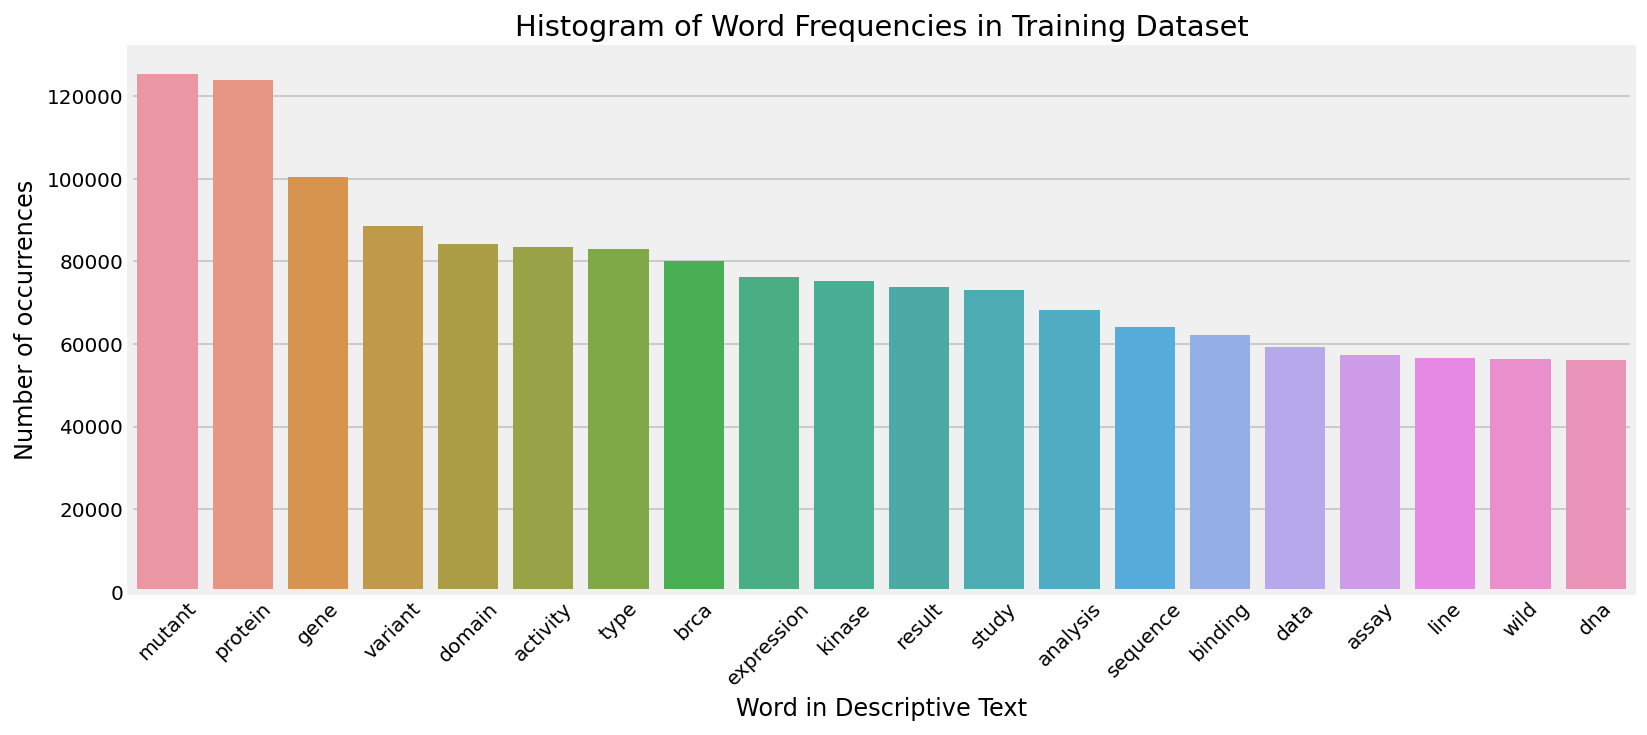

In [25]:
plt.figure(figsize=(12,5))
sns.barplot(indexes, values);
plt.xticks(indexes, labels, rotation=45);
plt.xlabel("Word in Descriptive Text")
plt.ylabel("Number of occurrences")
plt.title("Histogram of Word Frequencies in Training Dataset");

## Creation of dummy columns

In [26]:
train.head()

,id,gene,variation,class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small lung nsclc heter...
2,2,CBL,Q249E,2,abstract background non small lung nsclc heter...
3,3,CBL,N454D,3,recent evidence demonstrate acquire uniparenta...
4,4,CBL,L399V,4,oncogenic monomeric casitas b lineage lymphoma...


In [27]:
test.head()

,id,gene,variation,text
0,1,CHEK2,H371Y,incidence breast increase china recent decade ...
1,2,AXIN2,Truncating Mutations,unselected series colorectal carcinoma stratif...
2,3,WNT4,E216G,mycosis fungoides zary syndrome primary cutane...
3,4,SUCLA2,G118R,regulate progression cycle require sequential ...
4,5,BRAF,T599insTT,pilocytic astrocytoma pa emerge entity dysregu...


In [28]:
train.shape, test.shape

((3321, 5), (986, 4))

To ensure we get consistent dummy columns created across the train and test datasets, we combine them first, perform get_dummies, then split them apart.

In [29]:
# Create a temporary column called 'dataset' to help us distinguish whether
# each data point is belonging to the training or testing dataset
train['dataset'] = 'train'
test['dataset'] = 'test'

In [30]:
# Create temporary dataframe 'combined' that is a concatenation of the train and test dataframes
combined= pd.concat([train, test], axis=0)

In [31]:
combined.head()

,id,gene,variation,class,text,dataset
0,0,FAM58A,Truncating Mutations,1.0,cyclin dependent kinase cdks regulate variety ...,train
1,1,CBL,W802*,2.0,abstract background non small lung nsclc heter...,train
2,2,CBL,Q249E,2.0,abstract background non small lung nsclc heter...,train
3,3,CBL,N454D,3.0,recent evidence demonstrate acquire uniparenta...,train
4,4,CBL,L399V,4.0,oncogenic monomeric casitas b lineage lymphoma...,train


In [32]:
combined.shape

(4307, 6)

In [33]:
# Create the dummy columns - we set drop_first=False given that we can't be sure we have all
# possible values of 'gene' and 'variation' in our combined dataframe
combined = pd.get_dummies(combined, columns=['gene', 'variation'], drop_first=False)

In [34]:
# Split the combined dataset back to the training and testing datasets based on the 'dataset' column
train_prep = combined[combined['dataset']=='train'].copy()
train_prep.reset_index(inplace=True, drop=True)
train_prep.drop(['dataset'], axis=1, inplace=True)

test_prep = combined[combined['dataset']=='test'].copy()
test_prep.reset_index(inplace=True, drop=True)
test_prep.drop(['dataset', 'class'], axis=1, inplace=True)

In [35]:
train_prep['class'] = train_prep['class'].astype(int)

In [36]:
train_prep.head(3)

,id,class,text,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,...,variation_YAP1-TFE3 Fusion,variation_YWHAE-ROS1 Fusion,variation_ZC3H7B-BCOR Fusion,variation_ZNF198-FGFR1 Fusion,variation_null1313Y,variation_null189Y,variation_null262Q,variation_null267R,variation_null399R,variation_p61BRAF
0,0,1,cyclin dependent kinase cdks regulate variety ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,abstract background non small lung nsclc heter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,abstract background non small lung nsclc heter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
test_prep.head(3)

,id,text,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,gene_AGXT,...,variation_YAP1-TFE3 Fusion,variation_YWHAE-ROS1 Fusion,variation_ZC3H7B-BCOR Fusion,variation_ZNF198-FGFR1 Fusion,variation_null1313Y,variation_null189Y,variation_null262Q,variation_null267R,variation_null399R,variation_p61BRAF
0,1,incidence breast increase china recent decade ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,unselected series colorectal carcinoma stratif...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,mycosis fungoides zary syndrome primary cutane...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Readiness of Pre-processed Data for Modelling

In [38]:
train_prep.shape, test_prep.shape

((3321, 4325), (986, 4324))

- Both the training and testing datasets have undergone cleaning, lemmatisation and creation of dummy columns for the 'gene' and 'variation' features.
- We deem the volume and quality of the training and testing datasets to be sufficient for subsequent modelling.

## Data Export

In [39]:
train_prep.to_csv("../assets/train_prep.csv", index=False)
test_prep.to_csv("../assets/test_prep.csv", index=False)